In [ ]:
import numpy as np
import os,shutil,json
import glob
import pickle
import time
import random
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm

#from numba import njit, cuda

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torchvision import transforms, datasets

from PIL import Image
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

from RandAugment import RandAugment

import timm
from timm import create_model

import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.learner import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.vision.learner import _update_first_layer
from fastcore import *
from fastai.callback.progress import ProgressCallback
from fastai.callback.data import CudaCallback
from fastai.optimizer import OptimWrapper

from wwf.utils import *
from wwf.vision.timm import *

#from nfnets.agc import AGC

#from efficientnet_pytorch import EfficientNet

In [ ]:
model_names = timm.list_models('*resnext*', pretrained=True)
print(model_names)

['cspresnext50', 'gluon_resnext50_32x4d', 'gluon_resnext101_32x4d', 'gluon_resnext101_64x4d', 'gluon_seresnext50_32x4d', 'gluon_seresnext101_32x4d', 'gluon_seresnext101_64x4d', 'ig_resnext101_32x8d', 'ig_resnext101_32x16d', 'ig_resnext101_32x32d', 'ig_resnext101_32x48d', 'legacy_seresnext26_32x4d', 'legacy_seresnext50_32x4d', 'legacy_seresnext101_32x4d', 'resnext50_32x4d', 'resnext50d_32x4d', 'resnext101_32x8d', 'seresnext26d_32x4d', 'seresnext26t_32x4d', 'seresnext50_32x4d', 'skresnext50_32x4d', 'ssl_resnext50_32x4d', 'ssl_resnext101_32x4d', 'ssl_resnext101_32x8d', 'ssl_resnext101_32x16d', 'swsl_resnext50_32x4d', 'swsl_resnext101_32x4d', 'swsl_resnext101_32x8d', 'swsl_resnext101_32x16d', 'tv_resnext50_32x4d']


In [ ]:
os.chdir('train/') # Data_Path
current_path = os.getcwd() # current folder
print('current_path', current_path)

current_path /opt/ml/train


In [ ]:
load_df = pd.read_csv('train.csv')
load_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [ ]:
# from itertools import combinations
# p = combinations(range(1,6), 2)
# p = list(p)
li = []
li2 = []
# mask5c2 = [[],[],[],[],[],[],[],[],[],[]]
# maskpad5c2 = [[],[],[],[],[],[],[],[],[],[]]
for idx, row in load_df.iterrows():
    path = sorted(glob.glob('images/'+row.path+'/*'))
    li.append(path)
    li2.append([os.path.basename(x).split('.')[0][:-1] for x in path])
    #li.append(path)
    # for i, comb in enumerate(p):
    #     for j in [0,0,comb[0], comb[1], -1,-1]:
    #         mask5c2[i].append(path[j])
    #         maskpad5c2[i].append(os.path.basename(path[j]).split('.')[0][:-1])
        
            
#         mask5c2[i].append(path[0])
#         mask5c2[i].append(path[comb[0]])
#         mask5c2[i].append(path[comb[1]])
#         mask5c2[i].append(path[-1])
#         mask5c2[i].append(path[-1])
        
    #li2.append([os.path.basename(x).split('.')[0][:-1] for x in path)
flatten_li = list(np.concatenate(li).flat)
flatten_li2 = list(np.concatenate(li2).flat)
#mask5c2[0]

In [ ]:
def age2idx(age):
    if age < 30:
        return 0
    elif age >=60:
        return 2
    else:
        return 1
# gender = train_df['gender'].unique()
# mask = train_df['mask'].unique()
gender2idx = {o:i for i,o in enumerate(['female', 'male'])}
mask2idx = {o:i for i,o in enumerate(['incorrect_mas', 'mask', 'norma'])}

In [ ]:
train_df=[]
for row in load_df.itertuples(index=False):
    train_df.extend([list(row)]*7)
train_df = pd.DataFrame(train_df, columns=load_df.columns)
train_df['path']=flatten_li
train_df['mask']=flatten_li2

In [ ]:
train_df.head()

,id,gender,race,age,path,mask
0,000001,female,Asian,45,images/000001_female_Asian_45/incorrect_mask.jpg,incorrect_mas
1,000001,female,Asian,45,images/000001_female_Asian_45/mask1.jpg,mask
2,000001,female,Asian,45,images/000001_female_Asian_45/mask2.jpg,mask
3,000001,female,Asian,45,images/000001_female_Asian_45/mask3.jpg,mask
4,000001,female,Asian,45,images/000001_female_Asian_45/mask4.jpg,mask


In [ ]:

del train_df['id']
del train_df['race']
train_df['gender'] = train_df['gender'].apply(lambda x: gender2idx[x])
train_df['age'] = train_df['age'].apply(lambda x: age2idx(x))
train_df['mask'] = train_df['mask'].apply(lambda x: mask2idx[x])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


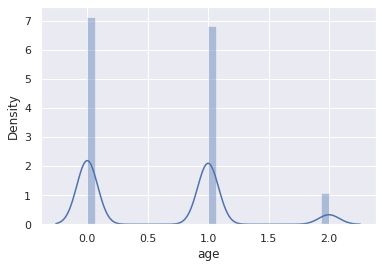

In [ ]:
sns.set_theme()
sns.distplot(train_df['age'], kde=True, bins=30)

In [ ]:
print(len(train_df[train_df['age']==0]),
      len(train_df[train_df['age']==1]),
      len(train_df[train_df['age']==2]))

8967 8589 1344


In [ ]:
print(len(train_df[train_df['age']==1][:3052]),
      len(train_df[train_df['age']==1][3829:]),
      len(train_df[train_df['age']==1][1914:4966]))

3052 4760 3052


In [ ]:
print(len(train_df[train_df['age']==0][:3052]),
      len(train_df[train_df['age']==0][5915:]),
      len(train_df[train_df['age']==0][2957:6009]))

3052 3052 3052


In [ ]:
a = pd.concat([train_df[train_df['age']==1][:3052], train_df[train_df['age']==0][:3052], train_df[train_df['age']==2]])
len(a)

7448

In [ ]:
mix_list0 = [
             train_df[train_df['age']==0][:3052],
             train_df[train_df['age']==0][5915:],
             train_df[train_df['age']==0][2957:6009]
             ]
mix_list1 = [
             train_df[train_df['age']==1][:3052],
             train_df[train_df['age']==1][3829:],
             train_df[train_df['age']==1][1914:4966]
             ]


train_df_list =  []
for i in range(3):
  for j in range(3):
    train_df_list.append(pd.concat([mix_list0[i], mix_list1[j], train_df[train_df['age']==2]]))
    

In [ ]:
len(train_df_list[0])

7448

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


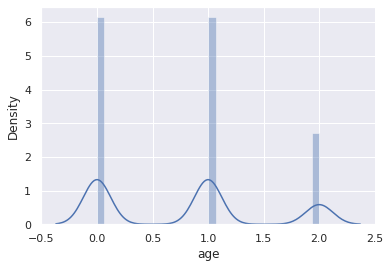

In [ ]:
sns.set_theme()
sns.distplot(train_df_list[0]['age'], kde=True, bins=30)

In [ ]:
a = train_df_list[0]
print(len(a[a['age']==0]),len(a[a['age']==1]),len(a[a['age']==2]))

3052 3052 1344


In [ ]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, df, tf):
        self.path = list(df['path'])
        #self.gender = list(df['gender'])
        self.age = list(df['age'])
        #self.mask = list(df['mask'])

        self.transform = transforms.Compose([
            # transforms.Resize((224, 224)),  
            transforms.CenterCrop((350,256)),
            transforms.Resize((260,260)),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])
            transforms.Normalize(mean=[0.4293, 0.4121, 0.4006],
                      std=[0.2050, 0.2111, 0.2141])
            ])
        if tf:
            self.transform.transforms.insert(0,RandAugment(3,4))

    def __len__(self): return len(self.path)

    def __getitem__(self,idx):
        #dealing with the image
        im = PIL.Image.open(self.path[idx]).convert('RGB')
        im = self.transform(im)


        #dealing with the labels
        #gender = torch.tensor(int(self.gender[idx]), dtype=torch.int64)
        age = torch.tensor(int(self.age[idx]), dtype=torch.int64)
        #mask = torch.tensor(int(self.mask[idx]), dtype=torch.int64)
        
        #return im.data, (gender, age, mask)
        return im.data, age

In [ ]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
class MultiTaskModel(nn.Module):
    """
    Creates a MTL model with the encoder from "arch" and with dropout multiplier ps.
    """
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_timm_body(arch, pretrained=False)        #fastai function that creates an encoder given an architecture
        #self.encoder = create_body(arch)
        #self.fc1 = create_head(1536, 2, ps=0.85)    #fastai function that creates a head
        self.fc2 = create_head(1408, 3, ps=0.5)
        #self.fc3 = create_head(1536, 3, ps=0.5)

    def forward(self,x):

        x = self.encoder(x)
        #gender = self.fc1(x)
        x = self.fc2(x)
        #mask = self.fc3(x)

        #return [gender, age, mask]
        return x

In [ ]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        #self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize(mean=[0.4293, 0.4121, 0.4006],
                      std=[0.2050, 0.2111, 0.2141]) #imagenet stats

    def predict(self,x):
        #x is a PIL Image
        img = PIL.Image.open('/opt/ml/eval/images/' + x).convert('RGB')
        x = transforms.CenterCrop((350,256))(img)
        x = transforms.Resize((260,260))(x)
        x = transforms.ToTensor()(x)
        #x = x.apply_tfms(self.tfms, size = 224)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        #gender = torch.softmax(preds[0],1).argmax().item()
        #age = torch.softmax(preds[1],1).argmax().item()
        age = torch.softmax(preds,1).argmax().item()
        return age

In [ ]:
# for i in range(0,9):
#     print('val set test : '+ str(i))
#     train_ds = MultiTaskDataset(train_df_list[0], tf=True)
#     valid_ds = MultiTaskDataset(train_df_list[i], tf=False)
#     train_dl = DataLoader(train_ds, batch_size = 64, shuffle=True, num_workers=4,device=default_device())
#     valid_dl = DataLoader(valid_ds, batch_size = 64, shuffle=True, num_workers=4,device=default_device())
#     data = DataLoaders(train_dl, valid_dl)
#     model = MultiTaskModel('ecaresnext26t_32x4d', ps=0.5)
#     metrics = [accuracy, F1Score(average='macro')]
#     learn = Learner(data, model, loss_func=CrossEntropyLossFlat(),opt_func=ranger, metrics=metrics, cbs=[CudaCallback])
#     learn.unfreeze()
#     learn.fit(5, 1e-3)

In [ ]:
for i in range(9):
    print('--------------trainset : ' + str(i)+'--------------------')
    train_ds = MultiTaskDataset(train_df_list[i], tf=True)
    valid_ds = MultiTaskDataset(train_df_list[i], tf=False)
    train_dl = DataLoader(train_ds, batch_size = 64, shuffle=True, num_workers=4,device=default_device())
    valid_dl = DataLoader(valid_ds, batch_size = 64, shuffle=True, num_workers=4,device=default_device())
    data = DataLoaders(train_dl, valid_dl)
    model = MultiTaskModel('efficientnet_b2', ps=0.5)
    metrics = [accuracy, F1Score(average='macro')]
    learn = Learner(data, model, loss_func=CrossEntropyLossFlat(),opt_func=ranger, metrics=metrics, cbs=[CudaCallback]).to_fp16()
    learn.unfreeze()
    learn.fit(70, 1e-4)
    trained_model = learn.model.cpu()
    sample_submission = pd.read_csv('/opt/ml/eval/info.csv')
    sample_submission.head()
    predicts = []
    ageneth_predictor = AgenethPredictor(trained_model)
    for path in tqdm(list(sample_submission['ImageID'])):
        p = ageneth_predictor.predict(path)
        predicts.append(p)
    sample_submission['ans'] = predicts
    sample_submission.to_csv('/opt/ml/tr/age_submission_555_'+str(i)+'.csv', mode='w', index=False)

--------------trainset : 0--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.218853,1.095782,0.413131,0.262427,00:41
1,1.181243,1.075366,0.431794,0.284191,00:41
2,1.153316,1.015264,0.591165,0.446188,00:41
3,1.103374,0.951089,0.623389,0.494319,00:41
4,1.064771,0.883553,0.622583,0.495882,00:41
5,1.008208,0.823059,0.655344,0.529226,00:42
6,0.981300,0.815531,0.644737,0.534765,00:42
7,0.961143,0.735745,0.704216,0.635791,00:41
8,0.943792,0.726286,0.719522,0.673332,00:42
9,0.931746,0.664179,0.741004,0.704477,00:41


100%|██████████| 12600/12600 [16:07<00:00, 13.02it/s]


--------------trainset : 1--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.201299,1.065802,0.468545,0.356291,00:51
1,1.162883,1.055808,0.367409,0.229414,00:51
2,1.143379,1.035264,0.591415,0.428183,00:51
3,1.117570,1.018349,0.608235,0.433915,00:51
4,1.092638,0.955212,0.556138,0.401204,00:51
5,1.071064,0.899356,0.626584,0.450414,00:51
6,1.039110,0.885875,0.664482,0.476261,00:51
7,0.998502,0.838046,0.667759,0.467536,00:51
8,0.992027,0.813548,0.695063,0.500090,00:51
9,0.962441,0.825525,0.666121,0.461868,00:51


100%|██████████| 12600/12600 [16:07<00:00, 13.02it/s]


--------------trainset : 2--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.211020,1.061993,0.428034,0.258382,00:41
1,1.187978,1.085667,0.334452,0.310079,00:42
2,1.166526,1.033274,0.578545,0.439528,00:41
3,1.158485,1.022809,0.581096,0.435356,00:41
4,1.122157,0.951255,0.590226,0.452048,00:42
5,1.116963,0.941518,0.595730,0.456863,00:42
6,1.076097,0.875118,0.627148,0.481768,00:41
7,1.046686,0.873332,0.637621,0.515707,00:41
8,1.026292,0.804334,0.649302,0.499142,00:42
9,1.018430,0.794855,0.668367,0.538716,00:41


100%|██████████| 12600/12600 [17:11<00:00, 12.22it/s]


--------------trainset : 3--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.210531,1.112951,0.272825,0.234507,00:42
1,1.178539,1.059055,0.452470,0.315082,00:42
2,1.165539,1.029665,0.517186,0.359078,00:42
3,1.119437,0.936607,0.634533,0.481378,00:42
4,1.092215,0.844508,0.661654,0.496523,00:42
5,1.053767,0.801540,0.676960,0.513238,00:43
6,0.999096,0.746899,0.679109,0.524775,00:42
7,0.972483,0.711230,0.713212,0.625491,00:42
8,0.926906,0.652210,0.726370,0.622345,00:42
9,0.914306,0.622582,0.760607,0.711963,00:42


100%|██████████| 12600/12600 [16:27<00:00, 12.76it/s]


--------------trainset : 4--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.223763,1.090888,0.449978,0.411220,00:51
1,1.174670,1.060557,0.543250,0.323482,00:52
2,1.152535,1.062477,0.593818,0.420508,00:53
3,1.124000,1.025985,0.569790,0.336392,00:52
4,1.090425,1.010446,0.641437,0.448034,00:52
5,1.070827,0.962014,0.671035,0.473616,00:52
6,1.031453,0.893228,0.672564,0.475891,00:52
7,1.009368,0.910928,0.678681,0.476731,00:52
8,1.007766,0.812337,0.695500,0.513894,00:52
9,0.970181,0.791163,0.721166,0.520462,00:52


100%|██████████| 12600/12600 [17:11<00:00, 12.21it/s]


--------------trainset : 5--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.222499,1.093764,0.413802,0.204429,00:44
1,1.201714,1.080430,0.510204,0.437953,00:45
2,1.161068,1.063066,0.431928,0.274862,00:44
3,1.114744,0.956592,0.640709,0.492325,00:43
4,1.074482,0.853722,0.681257,0.509171,00:43
5,1.048830,0.825633,0.683405,0.545813,00:42
6,1.008018,0.743601,0.705424,0.555533,00:42
7,0.965837,0.764486,0.690521,0.538213,00:42
8,0.951963,0.674099,0.727175,0.571098,00:43
9,0.932890,0.653779,0.756042,0.658887,00:42


100%|██████████| 12600/12600 [16:07<00:00, 13.02it/s]


--------------trainset : 6--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.208210,1.097764,0.418099,0.298735,00:41
1,1.191219,1.047695,0.541890,0.434455,00:42
2,1.176459,1.059450,0.431391,0.256766,00:42
3,1.144225,1.028008,0.533029,0.392406,00:41
4,1.116793,0.984267,0.489796,0.347043,00:42
5,1.089606,0.932899,0.570623,0.431634,00:42
6,1.055330,0.801193,0.687030,0.529433,00:42
7,1.014315,0.796534,0.671992,0.506499,00:42
8,0.994191,0.760260,0.691192,0.547279,00:42
9,0.969366,0.718108,0.706230,0.564112,00:42


100%|██████████| 12600/12600 [15:50<00:00, 13.26it/s]


--------------trainset : 7--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.233800,1.069933,0.513543,0.261632,00:51
1,1.199892,1.088619,0.490826,0.351241,00:51
2,1.172112,1.068194,0.515072,0.254831,00:51
3,1.146954,1.033003,0.519659,0.247314,00:52
4,1.135089,1.061849,0.533093,0.299848,00:51
5,1.117293,1.034459,0.521516,0.245069,00:51
6,1.102556,1.042025,0.541503,0.390174,00:51
7,1.074181,1.002053,0.541394,0.303697,00:51
8,1.084963,0.990210,0.530253,0.259044,00:51
9,1.059076,0.946442,0.562910,0.332798,00:51


100%|██████████| 12600/12600 [15:58<00:00, 13.15it/s]


--------------trainset : 8--------------------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.226076,1.065533,0.412863,0.210408,00:42
1,1.205765,1.085889,0.455693,0.345743,00:41
2,1.171649,1.067025,0.447234,0.317917,00:42
3,1.167110,1.061843,0.504565,0.384223,00:42
4,1.147794,1.055316,0.491004,0.364552,00:42
5,1.129658,1.031700,0.528867,0.404623,00:42
6,1.102856,1.010480,0.479055,0.331381,00:42
7,1.096506,0.965284,0.581767,0.464687,00:42
8,1.080725,0.921266,0.641380,0.488117,00:41
9,1.053544,0.884582,0.661923,0.498603,00:42


100%|██████████| 12600/12600 [16:01<00:00, 13.11it/s]
